# Bent waveguides (layout and simulation)

Step by step process:
1. Draw a bent waveguide and save it in a .gds file.
2. Load the bent waveguide using Meep.
3. Setup simulation environment.
4. Simulate FDTD and visualize results.
5. Compute loss and reflection of the bend.

In [33]:
# Import meep and mpb (from meep)
import meep as mp
from meep import mpb

# arrays
import numpy as np

# plotting
import matplotlib.pyplot as plt

# Debug info
print("Meep version:", mp.__version__)

Meep version: 1.17


In [34]:
import pya
import numpy as np

SIM_CELL = pya.LayerInfo(0, 0)
Si = pya.LayerInfo(1, 0)
MEEP_SOURCE1 = pya.LayerInfo(10, 0)
MEEP_PORT1 = pya.LayerInfo(20, 0)
MEEP_PORT2 = pya.LayerInfo(21, 0)

## Simulation Parameters

In [35]:
ring_radius = 10 # um
ring_width = 0.5 # um
pml_width = 1.0 # um
straight_wg_length = pml_width + 0.2 # um

# Simulation resolution
res = 128        # pixels/μm

## Step 1. Drawing a bent waveguide and saving into a temporary .gds file

In [36]:
from zeropdk.layout import layout_arc, layout_waveguide, layout_path, layout_box
from tempfile import NamedTemporaryFile

# Create a temporary filename
temp_file = NamedTemporaryFile(delete=False, suffix='.gds')
filename = temp_file.name

# Clean existing file
!rm {filename}

# Instantiate a layout and a top cell
layout = pya.Layout()
layout.dbu = 0.001
TOP = layout.create_cell("TOP")

# Unit vectors
ex = pya.DVector(1, 0)
ey = pya.DVector(0, 1)

# Draw circular bend
layout_arc(TOP, Si, - ring_radius*ey, ring_radius, ring_width, 0, np.pi/2)

# Extend the bend to avoid discontinuities
layout_waveguide(TOP, Si, [0*ex, - straight_wg_length*ex], ring_width)
layout_waveguide(TOP, Si, [-1*ring_radius*ey + ring_radius*ex, 
                           -straight_wg_length * ey - ring_radius*ey + ring_radius*ex], ring_width)

# Add the ports as 0-width paths
port_size = ring_width * 4.0

# Source port
layout_path(TOP, MEEP_SOURCE1, [-port_size/2*ey - 0.2*ex, port_size/2*ey - 0.2*ex], 0)
# Input port (immediately at the start of the bend)
layout_path(TOP, MEEP_PORT1,   [-port_size/2*ey, port_size/2*ey], 0)
# Output port (immediately at the end of the bend)
layout_path(TOP, MEEP_PORT2,   [-1*ring_radius*ey + ring_radius*ex - port_size/2*ex, 
                               -1*ring_radius*ey + ring_radius*ex + port_size/2*ex], 0)

# Draw simulation region
layout_box(TOP, SIM_CELL, 
           -1.0*ring_radius*ey - straight_wg_length * (ex + ey), # Bottom left point 
            1.0*ring_radius*ex + (straight_wg_length + port_size / 2) * (ex + ey),  # Top right point
           ex)

# Write to file
layout.write(filename)
print(f"Produced file {filename}.")
!ls -lh {filename}

Produced file /tmp/tmp4boe3y2e.gds.
-rw-rw-r-- 1 josh josh 2.4K Feb 25 15:21 /tmp/tmp4boe3y2e.gds


## Step 2. Load gds file into meep

### Visualization and simulation

If you choose a normal filename (not temporary), you can download the GDSII file from the cluster (see Files in MyAdroit dashboard) to see it with your local Klayout. Otherwise, let's get simulating:

In [37]:
gdsII_file = filename
CELL_LAYER = 0
SOURCE_LAYER = 10
Si_LAYER = 1
PORT1_LAYER = 20
PORT2_LAYER = 21

t_oxide = 1.0
t_Si = 0.22
t_SiO2 = 0.78

oxide = mp.Medium(epsilon=2.25)
silicon=mp.Medium(epsilon=12)

lcen = 1.55
fcen = 1/lcen
df = 0.2*fcen

cell_zmax =  0
cell_zmin =  0
si_zmax = 0.1
si_zmin = 0

# read cell size, volumes for source region and flux monitors,
# and coupler geometry from GDSII file
# WARNING: Once the file is loaded, the prism contents is cached and cannot be reloaded.
# SOLUTION: Use a different filename or restart the kernel

si_layer = mp.get_GDSII_prisms(silicon, gdsII_file, Si_LAYER, si_zmin, si_zmax)

cell = mp.GDSII_vol(gdsII_file, CELL_LAYER, cell_zmin, cell_zmax)
src_vol = mp.GDSII_vol(gdsII_file, SOURCE_LAYER, si_zmin, si_zmax)
p1 = mp.GDSII_vol(gdsII_file, PORT1_LAYER, si_zmin, si_zmax)
p2 = mp.GDSII_vol(gdsII_file, PORT2_LAYER, si_zmin, si_zmax)


sources = [mp.EigenModeSource(src=mp.GaussianSource(fcen,fwidth=df),
                              size=src_vol.size,
                              center=src_vol.center,
                              eig_band=1,
                              eig_parity=mp.NO_PARITY,
                              eig_match_freq=True)]

# Display simulation object
sim = mp.Simulation(resolution=res,
                    default_material=oxide,
                    eps_averaging=False,
                    subpixel_maxeval=1,
                    subpixel_tol=1,
                    cell_size=cell.size,
                    boundary_layers=[mp.PML(pml_width)],
                    sources=sources,
                    geometry=si_layer,
                    geometry_center=cell.center)

# Delete file created in previous cell

import os 
temp_file.close()
os.unlink(filename)

## Step 3. Setup simulation environment

This will load the python-defined parameters from the previous cell and instantiate a fast, C++ based, simulation environment using meep. It will also compute the eigenmode of the source, in preparation for the FDTD simulation.

In [38]:
sim.reset_meep()

# Could add monitors at many frequencies by looping over fcen
# Means one FDTD for many results!
mode1 = sim.add_mode_monitor(fcen, df, 25, mp.ModeRegion(volume=p1))
mode2 = sim.add_mode_monitor(fcen, df, 25, mp.ModeRegion(volume=p2))

# Let's store the frequencies that were generated by this mode monitor
mode1_freqs = np.array(mp.get_eigenmode_freqs(mode1))
mode2_freqs = np.array(mp.get_eigenmode_freqs(mode2))

sim.init_sim()

-----------
Initializing structure...
time for choose_chunkdivision = 0.00140905 s
Working in 2D dimensions.
Computational cell is 13.3984 x 13.3984 x 0 with resolution 128
     prism, center = (6.32432,-3.67568,0.05)
          height 0.1, axis (0,0,1), sidewall angle: 0 radians, 240 vertices:
          (9.75,-10,0)
          (9.749,-9.88,0)
          (9.747,-9.761,0)
          (9.743,-9.641,0)
          (9.738,-9.522,0)
          (9.732,-9.402,0)
          (9.724,-9.283,0)
          (9.714,-9.163,0)
          (9.703,-9.044,0)
          (9.691,-8.925,0)
          (9.677,-8.806,0)
          (9.661,-8.688,0)
          (9.644,-8.569,0)
          (9.626,-8.451,0)
          (9.606,-8.333,0)
          (9.585,-8.215,0)
          (9.563,-8.098,0)
          (9.539,-7.981,0)
          (9.513,-7.864,0)
          (9.486,-7.747,0)
          (9.458,-7.631,0)
          (9.428,-7.515,0)
          (9.397,-7.4,0)
          (9.364,-7.284,0)
          (9.33,-7.17,0)
          (9.295,-7.055,0)
          (9

grid initialization is 61.1074% done, 2.56345 s remaining
grid initialization is 64.5885% done, 2.19654 s remaining
grid initialization is 68.0696% done, 1.88061 s remaining
grid initialization is 71.5507% done, 1.59725 s remaining
grid initialization is 74.9848% done, 1.3348 s remaining
grid initialization is 78.4659% done, 1.10894 s remaining
grid initialization is 81.947% done, 0.893117 s remaining
grid initialization is 85.381% done, 0.693925 s remaining
grid initialization is 88.8151% done, 0.505124 s remaining
grid initialization is 5.17456% done, 73.7668 s remaining
grid initialization is 8.65566% done, 42.5117 s remaining
grid initialization is 12.1368% done, 29.1746 s remaining
grid initialization is 15.6179% done, 21.6257 s remaining
grid initialization is 19.099% done, 16.9651 s remaining
grid initialization is 22.5801% done, 13.7162 s remaining
grid initialization is 26.0612% done, 11.4743 s remaining
grid initialization is 29.5423% done, 9.62812 s remaining
grid initializa

### Verify that the structure makes sense.

Things to check:
- Are the sources and ports outside the PML?
- Are dimensions correct?
- Is the simulation region unnecessarily large?

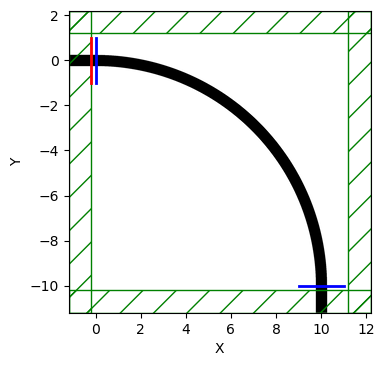

In [39]:
# If there is a warning that reads "The specified user volume
# is larger than the simulation domain and has been truncated",
# It has to do with some numerical errors between python and meep.
# Ignore.

f = plt.figure(dpi=100)
sim.plot2D(ax=f.gca())
plt.show()

Looks pretty good. Simulations at the high enough resolution required to avoid spurious reflections in the bend are very slow! This can be sped up quite a bit by running the code in parallel from the terminal. Later, we will put this notebook's code into a script and run it in parallel.

## Step 4. Simulate FDTD and Animate results

More detailed meep documentation available [here](https://meep.readthedocs.io/en/latest/Python_Tutorials/Basics/#transmittance-spectrum-of-a-waveguide-bend).

In [9]:
# Set to true to compute animation (may take a lot of memory)
compute_animation = True

In [10]:
# Setup and run the simulation

# The following line defines a stopping condition depending on the square
# of the amplitude of the Ez field at the port 2.
print(f"Stop condition: decay to 0.1% of peak value in the last {2.0/df:.1f} time units.")
stop_condition = mp.stop_when_fields_decayed(2.0/df,mp.Ez,p2.center,1e-3)
if compute_animation:
    f = plt.figure(dpi=100)
    animate = mp.Animate2D(sim,mp.Ez,f=f,normalize=True)
    sim.run(mp.at_every(1,animate), until_after_sources=stop_condition)
    plt.close()
else:
    sim.run(until_after_sources=stop_condition)

Stop condition: decay to 0.1% of peak value in the last 15.5 time units.
on time step 130 (time=0.507812), 0.0309304 s/step
on time step 256 (time=1), 0.067373 s/step
on time step 388 (time=1.51562), 0.0304337 s/step
on time step 517 (time=2.01953), 0.0311128 s/step
on time step 649 (time=2.53516), 0.0303462 s/step
on time step 778 (time=3.03906), 0.0311877 s/step
on time step 910 (time=3.55469), 0.0304483 s/step
on time step 1034 (time=4.03906), 0.0323587 s/step
on time step 1176 (time=4.59375), 0.0283598 s/step
on time step 1312 (time=5.125), 0.0294292 s/step
on time step 1450 (time=5.66406), 0.0290448 s/step
on time step 1578 (time=6.16406), 0.0313146 s/step
on time step 1708 (time=6.67188), 0.030845 s/step
on time step 1836 (time=7.17188), 0.0312636 s/step
on time step 1960 (time=7.65625), 0.0324725 s/step
on time step 2085 (time=8.14453), 0.0320334 s/step
on time step 2216 (time=8.65625), 0.0306497 s/step
on time step 2346 (time=9.16406), 0.030773 s/step
on time step 2482 (time=9.

on time step 20438 (time=79.8359), 0.0285828 s/step
on time step 20574 (time=80.3672), 0.0294706 s/step
on time step 20715 (time=80.918), 0.0283966 s/step
on time step 20853 (time=81.457), 0.0291766 s/step
on time step 20992 (time=82), 0.0290967 s/step
on time step 21135 (time=82.5586), 0.0281074 s/step
on time step 21272 (time=83.0938), 0.0292341 s/step
on time step 21415 (time=83.6523), 0.0281312 s/step
on time step 21553 (time=84.1914), 0.0291747 s/step
on time step 21695 (time=84.7461), 0.0282713 s/step
on time step 21834 (time=85.2891), 0.0288628 s/step
on time step 21976 (time=85.8438), 0.0281977 s/step
on time step 22115 (time=86.3867), 0.0287937 s/step
on time step 22255 (time=86.9336), 0.0285817 s/step
on time step 22393 (time=87.4727), 0.0291318 s/step
on time step 22531 (time=88.0117), 0.0290909 s/step
on time step 22671 (time=88.5586), 0.0287233 s/step
on time step 22809 (time=89.0977), 0.0291515 s/step
on time step 22953 (time=89.6602), 0.0278669 s/step
on time step 23091 

### Visualize results

Things to check:
- Was the simulation time long enough for the pulse to travel through port2 in its entirety? Given the automatic stop condition, this should be the case.

In [11]:
from IPython.display import Video, display
if compute_animation:
    # Save video as gif
    animate.to_mp4(10, 'media/bend.mp4')
    # Play video
    display(animate.to_jshtml(10))
else:
    # Load pre-computed video from .gif
    display(Video('media/bend.mp4'))

Generating MP4...


## Step 5. Compute loss and reflection of the bend

In [20]:
# Every mode monitor measures the power flowing through it in either the forward or backward direction
eig_mode1 = sim.get_eigenmode_coefficients(mode1, [1], eig_parity=mp.NO_PARITY)
eig_mode2 = sim.get_eigenmode_coefficients(mode2, [1], eig_parity=mp.NO_PARITY)

# First, we need to figure out which direction the "dominant planewave" k-vector is
# We can pick the first frequency (0) for that, assuming that for all simulated frequencies,
# The dominant k-vector will point in the same direction.
k1 = eig_mode1.kdom[0]
k2 = eig_mode2.kdom[0]

# eig_mode.alpha[0,0,0] corresponds to the forward direction, whereas
# eig_mode.alpha[0,0,1] corresponds to the backward direction

# For port 1, we are interested in the +x direction, so if k1.x is positive, select 0, otherwise 1
idx = (k1.x < 0) * 1
p1_thru_coeff = eig_mode1.alpha[0,:,idx]
p1_reflected_coeff = eig_mode1.alpha[0,:,1-idx]

# For port 2, we are interestred in the -y direction
idx = (k2.y > 0) * 1
p2_thru_coeff = eig_mode2.alpha[0,:,idx]
p2_reflected_coeff = eig_mode2.alpha[0,:,1-idx]

# transmittance
p2_trans = abs(p2_thru_coeff/p1_thru_coeff)**2
p2_reflected = abs(p1_reflected_coeff/p1_thru_coeff)**2

print("----------------------------------")
print(f"Parameters: radius={ring_radius:.1f}")
print(f"Frequencies: {mode1_freqs}")
print(f"Transmitted fraction: {p2_trans}")
print(f"Reflected fraction: {p2_reflected}")

MPB solved for omega_1(2.01141,0,0) = 0.618857 after 27 iters
MPB solved for omega_1(1.87474,0,0) = 0.580676 after 10 iters
MPB solved for omega_1(1.87463,0,0) = 0.580645 after 4 iters
MPB solved for omega_1(1.87463,0,0) = 0.580645 after 1 iters
Dominant planewave for band 1: (1.874630,-0.000000,0.000000)
MPB solved for omega_1(2.03004,0,0) = 0.624065 after 27 iters
MPB solved for omega_1(1.894,0,0) = 0.586052 after 10 iters
MPB solved for omega_1(1.89389,0,0) = 0.586022 after 4 iters
MPB solved for omega_1(1.89389,0,0) = 0.586022 after 1 iters
Dominant planewave for band 1: (1.893889,-0.000000,0.000000)
MPB solved for omega_1(2.04866,0,0) = 0.629273 after 26 iters
MPB solved for omega_1(1.91325,0,0) = 0.591428 after 10 iters
MPB solved for omega_1(1.91314,0,0) = 0.591398 after 4 iters
MPB solved for omega_1(1.91314,0,0) = 0.591398 after 1 iters
Dominant planewave for band 1: (1.913143,-0.000000,0.000000)
MPB solved for omega_1(2.06729,0,0) = 0.634483 after 26 iters
MPB solved for omeg

Dominant planewave for band 1: (0.000000,1.893889,0.000000)
MPB solved for omega_1(0,2.04866,0) = 0.629273 after 26 iters
MPB solved for omega_1(0,1.91325,0) = 0.591428 after 7 iters
MPB solved for omega_1(0,1.91314,0) = 0.591398 after 3 iters
MPB solved for omega_1(0,1.91314,0) = 0.591398 after 1 iters
Dominant planewave for band 1: (0.000000,1.913143,0.000000)
MPB solved for omega_1(0,2.06729,0) = 0.634483 after 23 iters
MPB solved for omega_1(0,1.9325,0) = 0.596804 after 7 iters
MPB solved for omega_1(0,1.93239,0) = 0.596774 after 3 iters
MPB solved for omega_1(0,1.93239,0) = 0.596774 after 1 iters
Dominant planewave for band 1: (0.000000,1.932393,0.000000)
MPB solved for omega_1(0,2.08591,0) = 0.639694 after 19 iters
MPB solved for omega_1(0,1.95174,0) = 0.60218 after 7 iters
MPB solved for omega_1(0,1.95164,0) = 0.602151 after 3 iters
MPB solved for omega_1(0,1.95164,0) = 0.602151 after 1 iters
Dominant planewave for band 1: (0.000000,1.951638,0.000000)
MPB solved for omega_1(0,2.

# Milestones

Goal: Compute the transmission profile for bend radii between 1.5um and 10um. 

- Q: Is the reflection significant for any radius? What explain the loss?
- Q: What is the formula total size of the simulation region? How many pixels are there?
- Q: If each pixel can host 3-dimensional E-field and H-field vectors with 64bit complex float stored in each dimension, how many megabytes of data needs to be stored at each time step? Is it feasible to save all this information throughout the FDTD simulation?
- Bonus: Collect the simulation runtime for each radius. How does it change with different radii?
- Bonus: At what resolution does the accuracy of the simulation start degrading? In other words, if halving the resolution only results in a 1% relative difference in the most important target metric, it is still a good resolution.

In [1]:
p2_trans_mag = np.abs(p2_thru_coeff/p1_thru_coeff)
p2_trans_phase = np.unwrap(np.angle(p2_thru_coeff/p1_thru_coeff))
p1_refl_mag = np.abs(p1_reflected_coeff/p1_thru_coeff)
p1_refl_phase = np.unwrap(np.angle(p1_reflected_coeff/p1_thru_coeff))

NameError: name 'np' is not defined

In [ ]:
#Write to csv file
import csv
with open('sparams.csv', mode='w') as sparams_file:
    sparam_writer = csv.writer(sparams_file, delimiter=',')
    for i in range(len(model_freqs)):
        sparam_writer.writerow([model_freqs[i],
                                p1_thru_coeff[i],
                                p2_thru_coeff[i],
                                p1_reflected_coeff[i],
                                p2_reflected_coeff[i]])

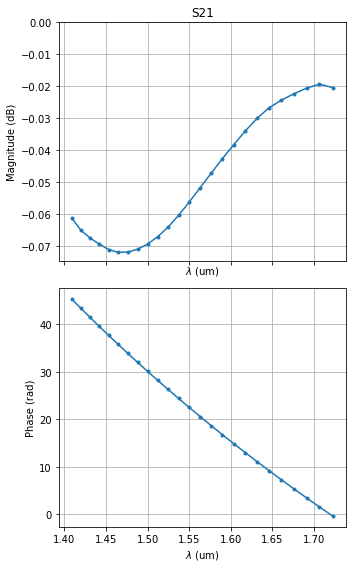

In [22]:
# Plot S21
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 8))
ax1.plot(1/mode1_freqs, 10 * np.log10(p2_trans_mag), '.-')
ax1.set_title("S21")
ax1.set_xlabel(r"$\lambda$ (um)")
ax1.set_ylabel("Magnitude (dB)")
ax1.set_ylim(None, 0)
ax1.grid()

ax2.plot(1/mode1_freqs, p2_trans_phase, '.-')
ax2.set_xlabel(r"$\lambda$ (um)")
ax2.set_ylabel("Phase (rad)")
ax2.grid()
plt.tight_layout()

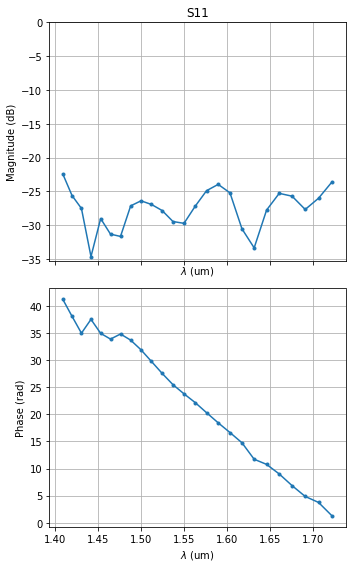

In [23]:
# Plot S11
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 8))
ax1.plot(1/mode1_freqs, 10 * np.log10(p1_refl_mag), '.-')
ax1.set_title("S11")
ax1.set_xlabel(r"$\lambda$ (um)")
ax1.set_ylabel("Magnitude (dB)")
ax1.set_ylim(None, 0)
ax1.grid()

ax2.plot(1/mode1_freqs, p1_refl_phase, '.-')
ax2.set_xlabel(r"$\lambda$ (um)")
ax2.set_ylabel("Phase (rad)")
ax2.grid()
plt.tight_layout()